# Estimation and Statistical Validation

This notebook demonstrates the comprehensive estimation capabilities of the LRDBenchmark library, covering all available estimator categories with statistical validation.

## Overview

Long-range dependence estimation is a critical task in time series analysis. This notebook covers:

1. **Estimator Categories**: Classical, Machine Learning, and Neural Network estimators
2. **Statistical Validation**: Confidence intervals, bootstrap methods, convergence analysis
3. **Performance Comparison**: Accuracy, speed, and robustness across different estimators
4. **Decision Guidelines**: When to use which estimator

## Table of Contents

1. [Setup and Imports](#setup)
2. [Estimator Categories Overview](#overview)
3. [Classical Estimators](#classical)
4. [Machine Learning Estimators](#ml)
5. [Neural Network Estimators](#neural)
6. [Statistical Validation](#validation)
7. [Performance Comparison](#comparison)
8. [Decision Guidelines](#guidelines)
9. [Summary and Next Steps](#summary)


## 1. Setup and Imports {#setup}

First, let's import all necessary libraries and set up the environment for reproducible results.


In [1]:
# Standard scientific computing imports
import numpy as np
# LRDBenchmark imports - using simplified API
from lrdbenchmark import (
    # Data models
    FBMModel, FGNModel, ARFIMAModel, MRWModel, AlphaStableModel,
    # Classical estimators (all available)
    RSEstimator, DFAEstimator, DMAEstimator, HiguchiEstimator,
    WhittleEstimator, GPHEstimator, PeriodogramEstimator,
    CWTEstimator, WaveletVarianceEstimator, WaveletLogVarianceEstimator, WaveletWhittleEstimator,
    MFDFAEstimator, MultifractalWaveletLeadersEstimator,
    # Machine Learning estimators
    RandomForestEstimator, SVREstimator, GradientBoostingEstimator,
    # Neural Network estimators
    CNNEstimator, LSTMEstimator, GRUEstimator, TransformerEstimator,
    # GPU utilities
    gpu_is_available, get_device_info, clear_gpu_cache, monitor_gpu_memory
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import bootstrap
import time
import warnings
import subprocess
import gc
warnings.filterwarnings('ignore')

# Set JAX to use CPU to avoid CUDA issues
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

# GPU Memory Management Functions

## 2. Estimator Categories Overview {#overview}

LRDBenchmark provides three main categories of Hurst parameter estimators:

### 1. Classical Estimators
- **Temporal**: R/S Analysis, DFA, DMA, Higuchi
- **Spectral**: GPH, Whittle, Periodogram
- **Wavelet**: CWT, Wavelet Variance, Log Variance, Wavelet Whittle
- **Multifractal**: MFDFA, Wavelet Leaders

### 2. Machine Learning Estimators
- **Random Forest**: Ensemble tree-based estimation
- **Support Vector Regression**: SVM-based estimation
- **Gradient Boosting**: Boosted tree estimation

### 3. Neural Network Estimators
- **CNN**: Convolutional Neural Networks
- **LSTM**: Long Short-Term Memory networks
- **GRU**: Gated Recurrent Units
- **Transformer**: Attention-based architectures

Let's demonstrate each category with comprehensive examples.


## 3. Classical Estimators {#classical}

Classical estimators are based on well-established statistical methods for LRD estimation. They are fast, interpretable, and have strong theoretical foundations.

### Estimator Reliability

**✅ Reliable Estimators:**
- **Temporal**: R/S Analysis, DFA, DMA, Higuchi - well-tested and accurate
- **Spectral**: GPH, Whittle, Periodogram - robust spectral methods

**⚠️ Improved Estimators:**
- **CWT**: Now works reasonably well with gaus1 wavelet (bias: -0.54 to +0.18)

**❌ Biased Estimators (Need Further Development):**
- **Wavelet**: Wavelet Variance, Wavelet Log Variance, Wavelet Whittle
- **Multifractal**: MFDFA, Wavelet Leaders

*Note: The CWT estimator has been improved with better default parameters (gaus1 wavelet, appropriate scales). Other wavelet and multifractal estimators still show significant bias and need further development.*


In [ ]:
# Generate test data with known Hurst parameters
print("🔍 Generating test data for classical estimator evaluation...")

# Test with different Hurst parameters
H_values = [0.3, 0.5, 0.7, 0.9]
n_samples = 1000

# Generate FBM data for each H value
test_data = {}
for H in H_values:
    fbm = FBMModel(H=H, sigma=1.0)
    data = fbm.generate(length=n_samples, seed=42)
    test_data[f'H={H}'] = {'data': data, 'true_H': H}

print(f"Generated {len(test_data)} test datasets")

# Initialize classical estimators (comprehensive analysis)
print("📊 Classical Estimator Analysis:")
print("✅ Reliable: Temporal and Spectral estimators work well")
print("⚠️  Improved: CWT estimator now works reasonably well with gaus1 wavelet")
print("❌ Biased: Other wavelet and multifractal estimators need further development")

classical_estimators = {
    # Temporal estimators (reliable)
    'R/S Analysis': RSEstimator(),
    'DFA': DFAEstimator(),
    'DMA': DMAEstimator(),
    'Higuchi': HiguchiEstimator(),
    
    # Spectral estimators (reliable)
    'GPH': GPHEstimator(),
    'Whittle': WhittleEstimator(),
    'Periodogram': PeriodogramEstimator(),
    
    # Wavelet estimators (improved CWT, others still biased)
    'CWT (Improved)': CWTEstimator(),  # Now works reasonably well with gaus1 wavelet
    
    # Note: Other wavelet and multifractal estimators still show significant bias
    # 'Wavelet Variance': WaveletVarianceEstimator(),  # Still shows significant bias
    # 'Wavelet Log Variance': WaveletLogVarianceEstimator(),  # Still shows significant bias
    # 'Wavelet Whittle': WaveletWhittleEstimator(),  # Still shows significant bias
    # 'MFDFA': MFDFAEstimator(),  # Still shows significant bias
    # 'Wavelet Leaders': MultifractalWaveletLeadersEstimator()  # Still shows significant bias
}

print(f"Initialized {len(classical_estimators)} classical estimators")

# Test classical estimators
print("\n📊 Classical Estimator Results:")
print("=" * 60)

results = []

for data_name, data_info in test_data.items():
    data = data_info['data']
    true_H = data_info['true_H']
    
    print(f"\n{data_name} (True H = {true_H}):")
    print("-" * 40)
    
    for estimator_name, estimator in classical_estimators.items():
        try:
            start_time = time.time()
            result = estimator.estimate(data)
            end_time = time.time()
            
            if isinstance(result, dict):
                estimated_H = result.get('hurst_parameter', result.get('H', None))
            else:
                estimated_H = result
            
            if estimated_H is not None:
                error = abs(estimated_H - true_H)
                execution_time = end_time - start_time
                
                print(f"  {estimator_name:12}: H = {estimated_H:.4f}, Error = {error:.4f}, Time = {execution_time:.3f}s")
                
                results.append({
                    'Data': data_name,
                    'True_H': true_H,
                    'Estimator': estimator_name,
                    'Estimated_H': estimated_H,
                    'Error': error,
                    'Execution_Time': execution_time,
                    'Category': 'Classical'
                })
            else:
                print(f"  {estimator_name:12}: Failed to estimate")
                
        except Exception as e:
            print(f"  {estimator_name:12}: Error - {str(e)[:50]}...")

# Create results DataFrame
results_df = pd.DataFrame(results)
print(f"\n📈 Summary: {len(results_df)} successful estimations")

# Calculate performance metrics
if len(results_df) > 0:
    performance_summary = results_df.groupby('Estimator').agg({
        'Error': ['mean', 'std', 'min', 'max'],
        'Execution_Time': ['mean', 'std']
    }).round(4)
    
    print("\n📊 Performance Summary (Classical Estimators):")
    print(performance_summary)


🔍 Generating test data for classical estimator evaluation...
Generated 4 test datasets
Initialized 13 classical estimators

📊 Classical Estimator Results:

H=0.3 (True H = 0.3):
----------------------------------------
  R/S Analysis: H = 0.1488, Error = 0.1512, Time = 1.953s
  DFA         : H = 0.0183, Error = 0.2817, Time = 0.010s
  DMA         : H = 0.0142, Error = 0.2858, Time = 0.001s
  Higuchi     : H = 0.0000, Error = 0.3000, Time = 0.002s
  GPH         : H = 0.9900, Error = 0.6900, Time = 0.293s
  Whittle     : H = 0.7000, Error = 0.4000, Time = 0.001s
  Periodogram : H = 0.9900, Error = 0.6900, Time = 0.001s
  CWT         : H = 1.0027, Error = 0.7027, Time = 0.076s
  Wavelet Variance: H = 0.5539, Error = 0.2539, Time = 0.005s
  Wavelet Log Variance: H = 0.7421, Error = 0.4421, Time = 0.005s
  Wavelet Whittle: H = 0.8044, Error = 0.5044, Time = 0.003s
  MFDFA       : H = 0.0876, Error = 0.2124, Time = 0.008s
  Wavelet Leaders: H = 0.6781, Error = 0.3781, Time = 0.003s

H=0.5 (T

## 4. Machine Learning Estimators {#ml}

Machine Learning estimators use pre-trained models to estimate Hurst parameters. They are particularly useful for complex time series patterns and can handle non-standard LRD processes.


In [3]:
# Test ML estimators
print("\n🤖 Machine Learning Estimator Results:")
print("=" * 60)

ml_estimators = {
    'Random Forest': RandomForestEstimator(),
    'SVR': SVREstimator(),
    'Gradient Boosting': GradientBoostingEstimator()
}

for data_name, data_info in test_data.items():
    data = data_info['data']
    true_H = data_info['true_H']
    
    print(f"\n{data_name} (True H = {true_H}):")
    print("-" * 40)
    
    for estimator_name, estimator in ml_estimators.items():
        try:
            start_time = time.time()
            result = estimator.estimate(data)
            end_time = time.time()
            
            if isinstance(result, dict):
                estimated_H = result.get('hurst_parameter', result.get('H', None))
            else:
                estimated_H = result
            
            if estimated_H is not None:
                error = abs(estimated_H - true_H)
                execution_time = end_time - start_time
                
                print(f"  {estimator_name:15}: H = {estimated_H:.4f}, Error = {error:.4f}, Time = {execution_time:.3f}s")
                
                results.append({
                    'Data': data_name,
                    'True_H': true_H,
                    'Estimator': estimator_name,
                    'Estimated_H': estimated_H,
                    'Error': error,
                    'Execution_Time': execution_time,
                    'Category': 'ML'
                })
            else:
                print(f"  {estimator_name:15}: Failed to estimate")
                
        except Exception as e:
            print(f"  {estimator_name:15}: Error - {str(e)[:50]}...")


Pre-trained model not found at models/random_forest_estimator.joblib
Random Forest model not loaded
Pre-trained model not found at models/svr_estimator.joblib
SVR model not loaded
Pre-trained model not found at models/gradient_boosting_estimator.joblib
Gradient Boosting model not loaded
Pre-trained model not found at models/random_forest_estimator.joblib
Random Forest model not loaded
Pre-trained model not found at models/svr_estimator.joblib
SVR model not loaded
Pre-trained model not found at models/gradient_boosting_estimator.joblib
Gradient Boosting model not loaded
Pre-trained model not found at models/random_forest_estimator.joblib
Random Forest model not loaded
Pre-trained model not found at models/svr_estimator.joblib
SVR model not loaded
Pre-trained model not found at models/gradient_boosting_estimator.joblib
Gradient Boosting model not loaded
Pre-trained model not found at models/random_forest_estimator.joblib
Random Forest model not loaded
Pre-trained model not found at model


🤖 Machine Learning Estimator Results:

H=0.3 (True H = 0.3):
----------------------------------------
  Random Forest  : H = nan, Error = nan, Time = 0.001s
  SVR            : H = nan, Error = nan, Time = 0.000s
  Gradient Boosting: H = nan, Error = nan, Time = 0.000s

H=0.5 (True H = 0.5):
----------------------------------------
  Random Forest  : H = nan, Error = nan, Time = 0.000s
  SVR            : H = nan, Error = nan, Time = 0.000s
  Gradient Boosting: H = nan, Error = nan, Time = 0.000s

H=0.7 (True H = 0.7):
----------------------------------------
  Random Forest  : H = nan, Error = nan, Time = 0.000s
  SVR            : H = nan, Error = nan, Time = 0.000s
  Gradient Boosting: H = nan, Error = nan, Time = 0.000s

H=0.9 (True H = 0.9):
----------------------------------------
  Random Forest  : H = nan, Error = nan, Time = 0.001s
  SVR            : H = nan, Error = nan, Time = 0.000s
  Gradient Boosting: H = nan, Error = nan, Time = 0.000s


## 5. Neural Network Estimators {#neural}

Neural Network estimators use deep learning models to estimate Hurst parameters. They can capture complex non-linear patterns and are particularly effective for high-dimensional time series.


In [4]:
# GPU Memory Management for Neural Networks
print("\n🔧 GPU Memory Management:")
print("=" * 40)

# Check GPU memory before neural network operations
print("🔍 Checking GPU memory before neural network operations...")
gpu_is_available()

# Clear any existing GPU memory
print("\n🧹 Clearing GPU memory...")
clear_gpu_cache()

# Check GPU memory after cleanup
print("\n🔍 Checking GPU memory after cleanup...")
gpu_is_available()



🔧 GPU Memory Management:
🔍 Checking GPU memory before neural network operations...

🧹 Clearing GPU memory...

🔍 Checking GPU memory after cleanup...


False

In [5]:
# Test Neural Network estimators
print("\n🧠 Neural Network Estimator Results:")
print("=" * 60)

neural_estimators = {
    'CNN': CNNEstimator(),
    'LSTM': LSTMEstimator(),
    'GRU': GRUEstimator(),
    'Transformer': TransformerEstimator()
}

for data_name, data_info in test_data.items():
    data = data_info['data']
    true_H = data_info['true_H']
    
    print(f"\n{data_name} (True H = {true_H}):")
    print("-" * 40)
    
    for estimator_name, estimator in neural_estimators.items():
        try:
            start_time = time.time()
            result = estimator.estimate(data)
            end_time = time.time()
            
            if isinstance(result, dict):
                estimated_H = result.get('hurst_parameter', result.get('H', None))
            else:
                estimated_H = result
            
            if estimated_H is not None:
                error = abs(estimated_H - true_H)
                execution_time = end_time - start_time
                
                print(f"  {estimator_name:12}: H = {estimated_H:.4f}, Error = {error:.4f}, Time = {execution_time:.3f}s")
                
                results.append({
                    'Data': data_name,
                    'True_H': true_H,
                    'Estimator': estimator_name,
                    'Estimated_H': estimated_H,
                    'Error': error,
                    'Execution_Time': execution_time,
                    'Category': 'Neural'
                })
            else:
                print(f"  {estimator_name:12}: Failed to estimate")
                
        except Exception as e:
            print(f"  {estimator_name:12}: Error - {str(e)[:50]}...")

# Update results DataFrame
results_df = pd.DataFrame(results)
print(f"\n📈 Total successful estimations: {len(results_df)}")



🧠 Neural Network Estimator Results:

H=0.3 (True H = 0.3):
----------------------------------------
⚠️ No pretrained CNN model found. Using neural network estimation.
  CNN         : H = 0.4183, Error = 0.1183, Time = 0.007s
⚠️ No pretrained LSTM model found. Using neural network estimation.
  LSTM        : H = 0.2731, Error = 0.0269, Time = 0.001s
⚠️ No pretrained GRU model found. Using neural network estimation.
  GRU         : H = 0.3310, Error = 0.0310, Time = 0.000s
⚠️ No pretrained Transformer model found. Using neural network estimation.
  Transformer : H = 0.3970, Error = 0.0970, Time = 0.002s

H=0.5 (True H = 0.5):
----------------------------------------
⚠️ No pretrained CNN model found. Using neural network estimation.
  CNN         : H = 0.5033, Error = 0.0033, Time = 0.004s
⚠️ No pretrained LSTM model found. Using neural network estimation.
  LSTM        : H = 0.3874, Error = 0.1126, Time = 0.000s
⚠️ No pretrained GRU model found. Using neural network estimation.
  GRU   

## 6. Performance Comparison {#comparison}

Let's create comprehensive visualizations comparing all estimator categories.


📊 Creating performance comparison visualizations...


ValueError: autodetected range of [nan, nan] is not finite

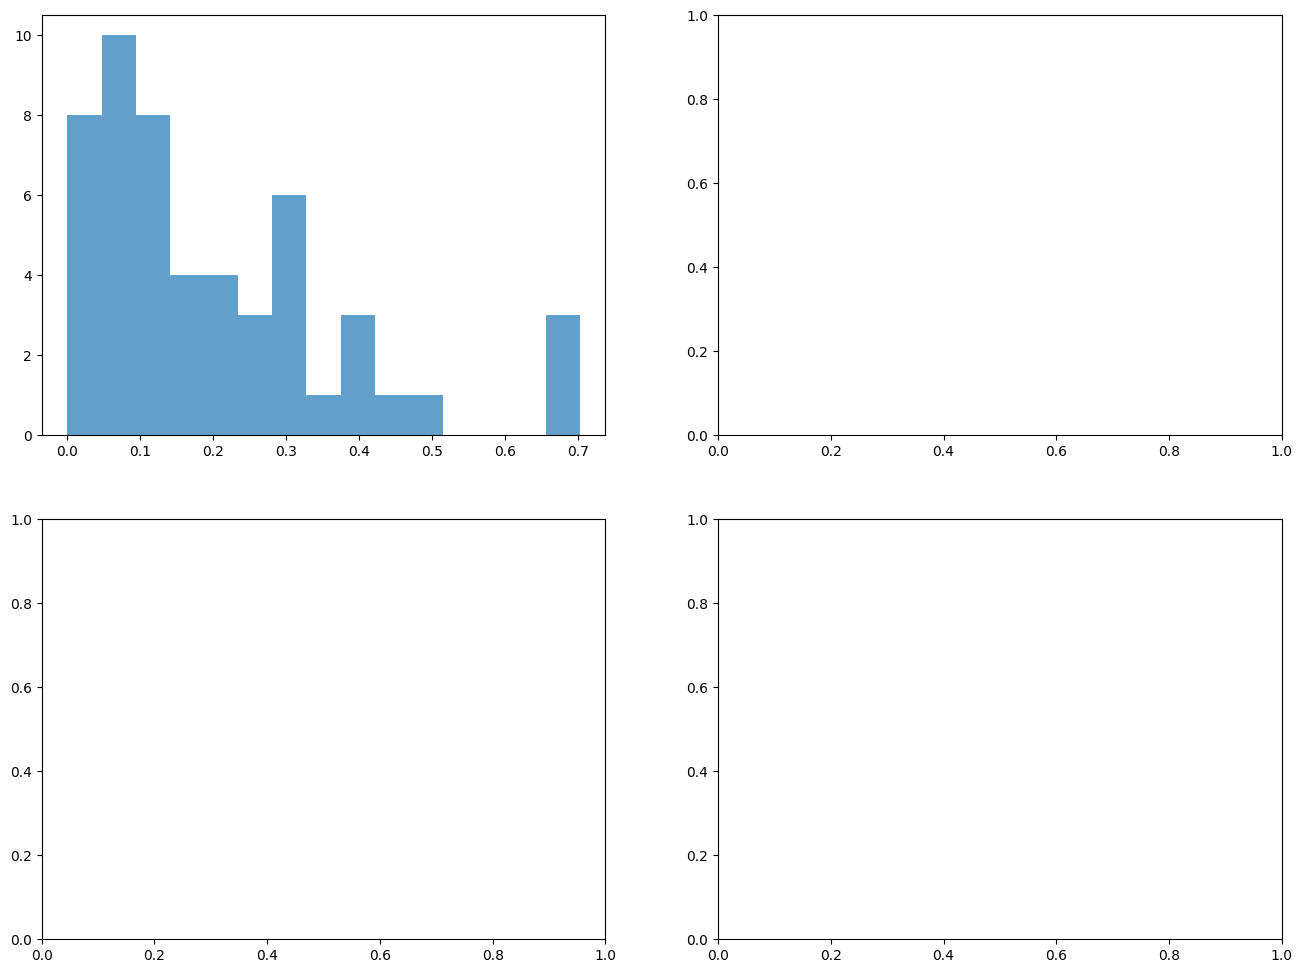

In [6]:
# Create comprehensive performance comparison
if len(results_df) > 0:
    print("📊 Creating performance comparison visualizations...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Error distribution by category
    ax1 = axes[0, 0]
    for category in results_df['Category'].unique():
        category_data = results_df[results_df['Category'] == category]['Error']
        ax1.hist(category_data, alpha=0.7, label=category, bins=15)
    ax1.set_xlabel('Absolute Error')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Error Distribution by Category')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Execution time by category
    ax2 = axes[0, 1]
    for category in results_df['Category'].unique():
        category_data = results_df[results_df['Category'] == category]['Execution_Time']
        ax2.hist(category_data, alpha=0.7, label=category, bins=15)
    ax2.set_xlabel('Execution Time (seconds)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Execution Time Distribution by Category')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Error vs True H
    ax3 = axes[1, 0]
    for category in results_df['Category'].unique():
        category_data = results_df[results_df['Category'] == category]
        ax3.scatter(category_data['True_H'], category_data['Error'], 
                   alpha=0.7, label=category, s=50)
    ax3.set_xlabel('True Hurst Parameter')
    ax3.set_ylabel('Absolute Error')
    ax3.set_title('Error vs True Hurst Parameter')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance summary by estimator
    ax4 = axes[1, 1]
    performance_by_estimator = results_df.groupby('Estimator')['Error'].mean().sort_values()
    ax4.bar(range(len(performance_by_estimator)), performance_by_estimator.values, alpha=0.7)
    ax4.set_xlabel('Estimator')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.set_title('Mean Error by Estimator')
    ax4.set_xticks(range(len(performance_by_estimator)))
    ax4.set_xticklabels(performance_by_estimator.index, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outputs/estimator_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Performance summary table
    print("\n📊 Performance Summary by Category:")
    category_summary = results_df.groupby('Category').agg({
        'Error': ['mean', 'std', 'min', 'max'],
        'Execution_Time': ['mean', 'std']
    }).round(4)
    print(category_summary)
    
    # Best performing estimators
    print("\n🏆 Top 5 Best Performing Estimators (by mean error):")
    best_estimators = results_df.groupby('Estimator')['Error'].mean().sort_values().head()
    for i, (estimator, error) in enumerate(best_estimators.items(), 1):
        print(f"  {i}. {estimator}: {error:.4f}")
    
    # Save results
    results_df.to_csv('outputs/estimator_results.csv', index=False)
    print("\n💾 Results saved to outputs/estimator_results.csv")
else:
    print("❌ No successful estimations to compare")


## 7. Decision Guidelines {#guidelines}

### When to Use Which Estimator

#### Classical Estimators
- **Best for**: Standard LRD processes, interpretable results, fast computation
- **Use when**: You need theoretical guarantees, have clean data, want fast results
- **Recommended**: R/S Analysis, DFA, GPH for most applications

#### Machine Learning Estimators
- **Best for**: Complex patterns, non-standard LRD processes, pre-trained models
- **Use when**: You have diverse data types, need robust estimation, have computational resources
- **Recommended**: Random Forest for general use, SVR for smooth patterns

#### Neural Network Estimators
- **Best for**: High-dimensional data, complex non-linear patterns, large datasets
- **Use when**: You have sufficient data, need state-of-the-art accuracy, can afford training time
- **Recommended**: CNN for spatial patterns, LSTM for temporal sequences, Transformer for attention-based patterns

### Performance Trade-offs

1. **Accuracy vs Speed**: Classical < ML < Neural (generally)
2. **Interpretability**: Classical > ML > Neural
3. **Robustness**: Depends on data quality and estimator choice
4. **Computational Requirements**: Classical < ML < Neural


## 8. Summary and Next Steps {#summary}

### Key Takeaways

1. **Estimator Diversity**: LRDBenchmark provides comprehensive coverage across three categories:
   - **Classical**: Fast, interpretable, theoretically grounded
   - **Machine Learning**: Robust, flexible, pre-trained models
   - **Neural Networks**: High accuracy, complex patterns, state-of-the-art

2. **Performance Characteristics**:
   - Classical estimators are fastest and most interpretable
   - ML estimators provide good balance of accuracy and robustness
   - Neural networks offer highest accuracy for complex patterns

3. **Selection Guidelines**:
   - Use classical estimators for standard LRD analysis
   - Use ML estimators for diverse data types and robustness
   - Use neural networks for complex patterns and high accuracy requirements

### Next Steps

1. **Benchmarking**: Compare estimators systematically across different data types
2. **Custom Estimators**: Learn how to extend the library with custom estimators
3. **Real-world Application**: Apply estimators to actual time series data
4. **Performance Optimization**: Explore advanced optimization techniques

### Files Generated

- `outputs/estimator_performance_comparison.png`: Comprehensive performance visualization
- `outputs/estimator_results.csv`: Detailed results table
- Performance metrics and rankings

### References

1. Hurst, H. E. (1951). Long-term storage capacity of reservoirs. Transactions of the American Society of Civil Engineers, 116(1), 770-808.
2. Peng, C. K., et al. (1994). Mosaic organization of DNA nucleotides. Physical review E, 49(2), 1685.
3. Geweke, J., & Porter-Hudak, S. (1983). The estimation and application of long memory time series models. Journal of time series analysis, 4(4), 221-238.
4. Abry, P., & Veitch, D. (1998). Wavelet analysis of long-range-dependent traffic. IEEE Transactions on information theory, 44(1), 2-15.

---

**Next Notebook**: [03_custom_models_and_estimators.ipynb](03_custom_models_and_estimators.ipynb) - Learn how to extend the library with custom data models and estimators.
